In [1]:
import pandas as pd
from glob import glob
import re
import matplotlib.pyplot as plt
import numpy as np
import scipy
from datetime import datetime

In [2]:
pd.set_option('display.max_colwidth',100)
pd.set_option('max_rows',1200)
pd.set_option('float_format', '{:d}'.format)

In [3]:
src_data = r'c:\Users\jaromir\OneDrive\UoM\100_Disertation\02_SrcData\03_RawData'

In [4]:
filenames = glob(src_data+'\$*.csv')

In [5]:
len(filenames)

12

In [6]:
df = pd.DataFrame()
for file in filenames:
    # read a csv from source folder
    print(file)
    data = pd.read_csv(file, encoding = 'utf-8') # dtype = data_types_raw
    # parese the name of the file to extract the ticker name and save it 
    # as a new attribute
    data['ticker'] = re.search(r'\$[A-Z]+_',file).group(0)[1:-1]
    # concatenate the csv with the rest of the DataFrame
    df = pd.concat([df, data], axis=0, sort = False, ignore_index = True)
df.drop(labels = 'Unnamed: 0', inplace=True, axis=1)

c:\Users\jaromir\OneDrive\UoM\100_Disertation\02_SrcData\03_RawData\$AAPL_2020-01-01_2020-06-30.csv


c:\Users\jaromir\Anaconda3\envs\disProject\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,4,5,6,7,9,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


c:\Users\jaromir\OneDrive\UoM\100_Disertation\02_SrcData\03_RawData\$AMZN_2020-01-01_2020-06-30.csv
c:\Users\jaromir\OneDrive\UoM\100_Disertation\02_SrcData\03_RawData\$BABA_2020-01-01_2020-06-30.csv
c:\Users\jaromir\OneDrive\UoM\100_Disertation\02_SrcData\03_RawData\$DLT_2020-01-01_2020-06-30.csv
c:\Users\jaromir\OneDrive\UoM\100_Disertation\02_SrcData\03_RawData\$GILD_2020-01-01_2020-06-30.csv
c:\Users\jaromir\OneDrive\UoM\100_Disertation\02_SrcData\03_RawData\$HLT_2020-01-01_2020-06-30.csv
c:\Users\jaromir\OneDrive\UoM\100_Disertation\02_SrcData\03_RawData\$JNJ_2020-01-01_2020-06-30.csv
c:\Users\jaromir\OneDrive\UoM\100_Disertation\02_SrcData\03_RawData\$MAR_2020-01-01_2020-06-30.csv
c:\Users\jaromir\OneDrive\UoM\100_Disertation\02_SrcData\03_RawData\$MCD_2020-01-01_2020-06-30.csv
c:\Users\jaromir\OneDrive\UoM\100_Disertation\02_SrcData\03_RawData\$MSFT_2020-01-01_2020-06-30.csv
c:\Users\jaromir\OneDrive\UoM\100_Disertation\02_SrcData\03_RawData\$QSR_2020-01-01_2020-06-30.csv
c:\Use

In [7]:
df_shape_raw = df.shape[0]
print(f"{df_shape_raw} rows loaded.")

436313 rows loaded.


### remove duplicate and invalid rows with NaN or Header values

In [8]:
df_counts = pd.DataFrame()
counts_raw = df.groupby(['ticker']).text.count()
df_counts['raw_data_count'] = counts_raw

In [9]:
# remove duplicates
df.drop_duplicates(subset = ["ticker","permalink","date"], keep = 'first', inplace = True)

# calculates dropped rows
counts_duplicates =  df.groupby(['ticker']).text.count()
df_counts['duplicates'] = counts_raw - counts_duplicates

In [10]:
# drop all rows with only NaN values
df.drop(labels = df.loc[df.iloc[:,:-1].isna().all(axis=1),:].index , axis=0, inplace=True)

# calculates dropped rows
counts_nan = df.groupby(['ticker']).text.count() 
df_counts['NaN'] = counts_duplicates - counts_nan

In [11]:
# drop all rows no text
df.drop(labels = df.loc[df.text.isna(),:].index , axis=0, inplace=True)

# calculates dropped rows
counts_missing_text = df.groupby(['ticker']).text.count() 
df_counts['missing_text'] = counts_duplicates - counts_missing_text

In [12]:
# drop all rows with headers in it
df.drop(labels = df[df.username == 'username'].index , axis=0, inplace=True)

# calculates dropped rows
counts_header =  df.groupby(['ticker']).text.count()
df_counts['headers'] = counts_nan - counts_header

In [13]:
%%time
# set datetime datatype
df.date = pd.to_datetime(df.date, utc=True, errors = 'coerce')

Wall time: 839 ms


In [14]:
# drop all values which fall outside of the range 2020-01-01 : 2020:06:30
df.drop(labels=df[(df.date.dt.date < pd.to_datetime('2020-01-01')) | (df.date.dt.date > pd.to_datetime('2020-06-30'))].index,
        axis=0 ,
        inplace = True)
df.reset_index(drop=True, inplace=True)

# calculates dropped rows
counts_out_of_range =  df.groupby(['ticker']).text.count()
df_counts['oor'] = counts_header - counts_out_of_range

In [15]:
# drop all rows with missing username
df.drop(labels = df[df.username.isna()].index , axis=0, inplace=True)

# calculates dropped rows
counts_missing_user =  df.groupby(['ticker']).text.count()
df_counts['missing_user'] = counts_header - counts_missing_user

In [16]:
df_counts['Total'] = df_counts.iloc[:,0] - df_counts.iloc[:,1:].sum(axis=1)

In [17]:
df_counts.loc['Total']= df_counts.sum()

In [18]:
df_counts

,raw_data_count,duplicates,NaN,missing_text,headers,oor,missing_user,Total
ticker,,,,,,,,
AAPL,131420,5206,0,0,1,4,4,126205
AMZN,105171,5029,0,0,0,5,5,100132
BABA,31418,1565,0,0,0,3,3,29847
DLT,1945,147,0,0,0,4,4,1790
GILD,39527,1169,0,0,1,5,5,38347
HLT,3399,216,0,0,1,6,6,3170
JNJ,16157,824,0,0,1,6,6,15320
MAR,5392,300,0,0,0,4,4,5084
MCD,9859,505,0,0,0,7,7,9340


### Set proper datatypes

In [19]:
data_types_raw = {  'username': 'object',
                'to': 'object',
                'text': 'object',
                'retweets': 'int64',
                'favorites': 'int64',
                'replies': 'int64',
                'id': 'int64',
                'permalink': 'object',
                'author_id': 'int64',
                'date': 'object',
                'formatted_date': 'object',
                'hashtags': 'object',
                'mentions': 'object',
                'geo': 'object',
                'urls': 'object',
                'ticker': 'object' }

In [20]:
df = df.astype(data_types_raw)

## Check size and inspect

In [21]:
df.memory_usage(deep=True).sum()/1024**2

408.5095958709717

In [22]:
df.head()

,username,to,text,retweets,favorites,replies,id,permalink,author_id,date,formatted_date,hashtags,mentions,geo,urls,ticker
0,DoejiStar,NaN,2019 Jan 2nd (22:30gmt) $JPY flash crash backdrop: - risk aversion sentiment on political risks ...,0,2,0,1212522035525476352,https://twitter.com/DoejiStar/status/1212522035525476352,507108497,2020-01-01 23:52:35+00:00,Wed Jan 01 23:52:35 +0000 2020,#Caixin,NaN,NaN,NaN,AAPL
1,PigOfFed,MarcoMNYC,"Should've been $spx 4,000 i mean the fed balance sheet is never going down again, $aapl at 400 &...",0,1,0,1212521491398565894,https://twitter.com/PigOfFed/status/1212521491398565894,1182741182310486016,2020-01-01 23:50:25+00:00,Wed Jan 01 23:50:25 +0000 2020,NaN,NaN,NaN,NaN,AAPL
2,mikeharrisNY,NaN,Market driver 2019. $AAPL had highest approx. turnover (price x volume) in $DJIA,1,12,0,1212520476129583104,https://twitter.com/mikeharrisNY/status/1212520476129583104,179571631,2020-01-01 23:46:23+00:00,Wed Jan 01 23:46:23 +0000 2020,NaN,NaN,NaN,NaN,AAPL
3,maythefroth,business,$AAPL He who is closest to the consumer wins.,0,0,0,1212519746073030658,https://twitter.com/maythefroth/status/1212519746073030658,940149583459491840,2020-01-01 23:43:29+00:00,Wed Jan 01 23:43:29 +0000 2020,NaN,NaN,NaN,https://twitter.com/business/status/1212516202620301312,AAPL
4,_steve2_,NaN,Come Sail Away http://With.me Tim @tim_cook $aapl it will be fine,0,1,0,1212519187333156874,https://twitter.com/_steve2_/status/1212519187333156874,3193289931,2020-01-01 23:41:16+00:00,Wed Jan 01 23:41:16 +0000 2020,NaN,@tim_cook,NaN,http://With.me,AAPL


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417476 entries, 0 to 417475
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   username        417476 non-null  object
 1   to              66987 non-null   object
 2   text            417476 non-null  object
 3   retweets        417476 non-null  int64 
 4   favorites       417476 non-null  int64 
 5   replies         417476 non-null  int64 
 6   id              417476 non-null  int64 
 7   permalink       417476 non-null  object
 8   author_id       417476 non-null  int64 
 9   date            417476 non-null  object
 10  formatted_date  417476 non-null  object
 11  hashtags        127113 non-null  object
 12  mentions        42820 non-null   object
 13  geo             0 non-null       object
 14  urls            192731 non-null  object
 15  ticker          417476 non-null  object
dtypes: int64(5), object(11)
memory usage: 54.1+ MB


In [24]:
categorical_data_types = {  'username': 'category',
                            'to': 'category',
                            'hashtags': 'category',
                            'mentions': 'category',
                            'ticker': 'category' }

In [25]:
df = df.astype(categorical_data_types)

In [26]:
# set datetime datatype
# df.formatted_date = pd.to_datetime(df.formatted_date, utc=True, errors = 'coerce')

In [27]:
def reduce_mem_usage(df, verbose=True):
    """ optimize memory usage by selecting an optimal datatype for each numeric feature """
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 \
                                                                                      * (start_mem - end_mem) / start_mem))
    return df

In [28]:
%%time
df = reduce_mem_usage(df)

Mem. usage decreased to 313.71 Mb (2.2% reduction)
Wall time: 17.5 s


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417476 entries, 0 to 417475
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   username        417476 non-null  category
 1   to              66987 non-null   category
 2   text            417476 non-null  object  
 3   retweets        417476 non-null  int16   
 4   favorites       417476 non-null  int16   
 5   replies         417476 non-null  int16   
 6   id              417476 non-null  int64   
 7   permalink       417476 non-null  object  
 8   author_id       417476 non-null  int64   
 9   date            417476 non-null  object  
 10  formatted_date  417476 non-null  object  
 11  hashtags        127113 non-null  category
 12  mentions        42820 non-null   category
 13  geo             0 non-null       object  
 14  urls            192731 non-null  object  
 15  ticker          417476 non-null  category
dtypes: category(5), int16(3), int64(2), ob

In [30]:
# drop unnecessary Column1 and geo
df = df.drop(['geo','formatted_date','permalink'], axis = 1)

## Regroup tweets to correspond with market opening times 

In [31]:
df1 = df.copy()

In [32]:
df = df1.copy()

In [33]:
def numConcat(a):
    return int(f"{a[0]}{a[1]:02}")

In [34]:
# tied afterhours with the next day

# date from Twitter is in UTC, NYSE's opening times are 2:30 p.m. to 9 p.m.
# for two consecutive days A and B, anything after 9pm on day A untill 9pm on B is day B
# weekend traffic is grouped together with Monday 

df['weekday'] = df.date.dt.weekday
df['hour'] = df.date.dt.hour
df['minute'] = df.date.dt.minute
df['date_short'] = pd.to_datetime(df.date.dt.date)
df['army_time'] = df[['hour','minute']].apply(numConcat, axis=1)

In [35]:
df['sentiment_collection_period'] = df['weekday']
df['sentiment_collection_date'] = pd.to_datetime(df.date.dt.date)

In [36]:
# tweets are more or less equally distributed across all weekdays with a clear drop over the weekends
day_distribution_raw = df.groupby(['weekday']).id.count()
day_distribution_raw

weekday
0    70116
1    72761
2    74521
3    75349
4    68250
5    28035
6    28444
Name: id, dtype: int64

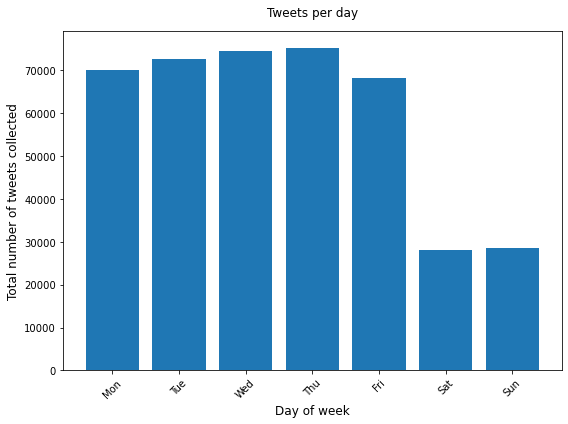

In [37]:
plt.figure(figsize=(8,6))
plt.bar(day_distribution_raw.index, day_distribution_raw.values)
plt.xticks(range(7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], rotation=45)
plt.title('Tweets per day', fontsize=12, pad=15)
plt.xlabel('Day of week', fontsize=12)
plt.ylabel('Total number of tweets collected', fontsize=12)
plt.tight_layout()
plt.show()

In [38]:
# sentiment collection period indicates to which day of the week the tweets belongs
# aka. any tweets after 21:30 belongs to the next day
# tweets from sunday = 6 belong to monday = 0 , hence the modulo 7

df['sentiment_collection_period'].mask(df.army_time > 2130 , (df.weekday + 1) % 7, inplace= True)

In [39]:
# tweets which are moves to the weeknd are also counted as Monday
df['sentiment_collection_period'].mask((df.sentiment_collection_period.isin([5,6])), 0, inplace = True)

In [40]:
df.loc[df.date_short == '2020-01-07',['date','date_short','weekday','hour','minute','army_time','sentiment_collection_period','sentiment_collection_date']]

,date,date_short,weekday,hour,minute,army_time,sentiment_collection_period,sentiment_collection_date
3723,2020-01-07 23:55:38+00:00,2020-01-07,1,23,55,2355,2,2020-01-07
3724,2020-01-07 23:51:49+00:00,2020-01-07,1,23,51,2351,2,2020-01-07
3725,2020-01-07 23:51:46+00:00,2020-01-07,1,23,51,2351,2,2020-01-07
3726,2020-01-07 23:50:00+00:00,2020-01-07,1,23,50,2350,2,2020-01-07
3727,2020-01-07 23:49:06+00:00,2020-01-07,1,23,49,2349,2,2020-01-07
...,...,...,...,...,...,...,...,...
398610,2020-01-07 15:06:57+00:00,2020-01-07,1,15,6,1506,1,2020-01-07
398611,2020-01-07 14:25:38+00:00,2020-01-07,1,14,25,1425,1,2020-01-07
398612,2020-01-07 13:28:40+00:00,2020-01-07,1,13,28,1328,1,2020-01-07
398613,2020-01-07 05:36:02+00:00,2020-01-07,1,5,36,536,1,2020-01-07


In [41]:
# sentiment_collection_date givesa a specific date for sentiment collection period
# in other words, sentiment collection period is a dt.weekday for sentiment_collection_date

df['sentiment_collection_date'].mask( (df.weekday.isin([0,1,2,3])) & (df.army_time > 2130), df['sentiment_collection_date'] + pd.DateOffset(1), inplace = True)
df['sentiment_collection_date'].mask( (df.weekday == 4) & (df.sentiment_collection_period == 0), df['sentiment_collection_date'] + pd.DateOffset(3), inplace = True)
df['sentiment_collection_date'].mask( (df.weekday == 5) & (df.sentiment_collection_period == 0), df['sentiment_collection_date'] + pd.DateOffset(2), inplace = True)
df['sentiment_collection_date'].mask( (df.weekday == 6) & (df.sentiment_collection_period == 0), df['sentiment_collection_date'] + pd.DateOffset(1), inplace = True)

In [42]:
df.loc[df.date_short == '2020-01-07',['date','date_short','weekday','hour','minute','army_time','sentiment_collection_period','sentiment_collection_date']]

,date,date_short,weekday,hour,minute,army_time,sentiment_collection_period,sentiment_collection_date
3723,2020-01-07 23:55:38+00:00,2020-01-07,1,23,55,2355,2,2020-01-08
3724,2020-01-07 23:51:49+00:00,2020-01-07,1,23,51,2351,2,2020-01-08
3725,2020-01-07 23:51:46+00:00,2020-01-07,1,23,51,2351,2,2020-01-08
3726,2020-01-07 23:50:00+00:00,2020-01-07,1,23,50,2350,2,2020-01-08
3727,2020-01-07 23:49:06+00:00,2020-01-07,1,23,49,2349,2,2020-01-08
...,...,...,...,...,...,...,...,...
398610,2020-01-07 15:06:57+00:00,2020-01-07,1,15,6,1506,1,2020-01-07
398611,2020-01-07 14:25:38+00:00,2020-01-07,1,14,25,1425,1,2020-01-07
398612,2020-01-07 13:28:40+00:00,2020-01-07,1,13,28,1328,1,2020-01-07
398613,2020-01-07 05:36:02+00:00,2020-01-07,1,5,36,536,1,2020-01-07


In [43]:
# The distribution is changed, because weekend tweets are moved to monday and night tweets have been moved to the other day
day_distribution_mod = df.groupby(['sentiment_collection_period']).id.count()
day_distribution_mod

sentiment_collection_period
0    124808
1     72033
2     75163
3     73949
4     71523
Name: id, dtype: int64

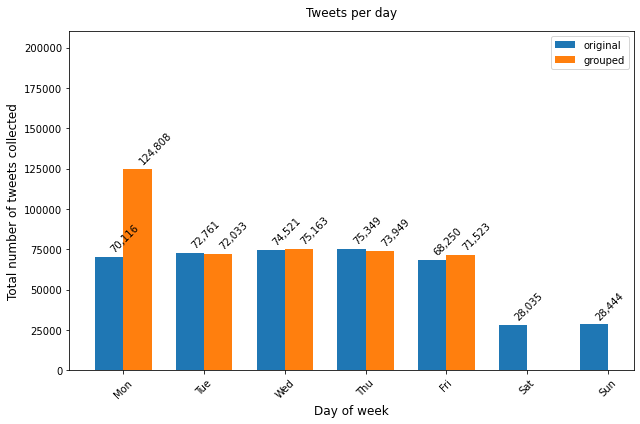

In [44]:
width = 0.35

fig, ax = plt.subplots(figsize=(9,6))

ax1 = ax.bar(day_distribution_raw.index - width/2, day_distribution_raw.values, width = width, label='original')
ax2 = ax.bar(day_distribution_mod.index + width/2, day_distribution_mod.values, width = width, label='grouped')
plt.xticks(range(7),['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], rotation=45)
plt.ylim(0,210*10**3)
plt.title('Tweets per day', fontsize=12, pad=15)
plt.xlabel('Day of week', fontsize=12)
plt.ylabel('Total number of tweets collected', fontsize=12)
plt.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:,}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='left', va='bottom', rotation=45)

autolabel(ax1)
autolabel(ax2)

plt.tight_layout()
plt.show()

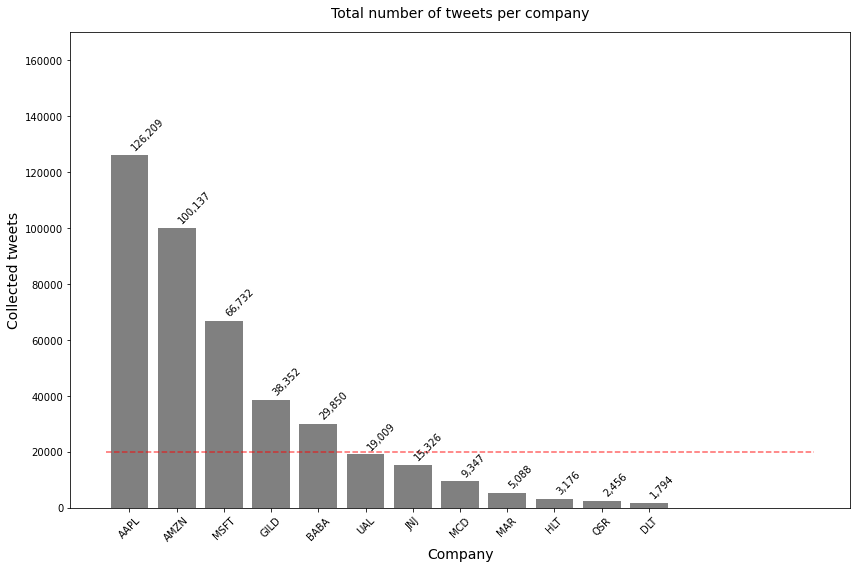

In [45]:
fig_name = 'Total number of tweets per company'
fig, ax = plt.subplots(figsize=(12,8))

data = df.groupby(['ticker']).id.count().sort_values(ascending=False)

ax1 = ax.bar(data.index, data.values, color='gray')
ax2 = ax.hlines(y=20000, xmin=-0.5, xmax=14.5, linestyles = 'dashed', color = 'red', alpha=0.6)

plt.xticks(rotation=45)
plt.ylim(0,170000)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:,}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='left', va='bottom', rotation=45)

autolabel(ax1)
plt.title(fig_name, fontsize=14, pad = 15)
plt.xlabel('Company', fontsize=14)
plt.ylabel('Collected tweets', fontsize=14)

plt.tight_layout()
plt.savefig(r'c:\Users\jaromir\OneDrive\UoM\100_Disertation\05_Dissertation\01_Figures\\'+fig_name+'.png')
        
plt.show()

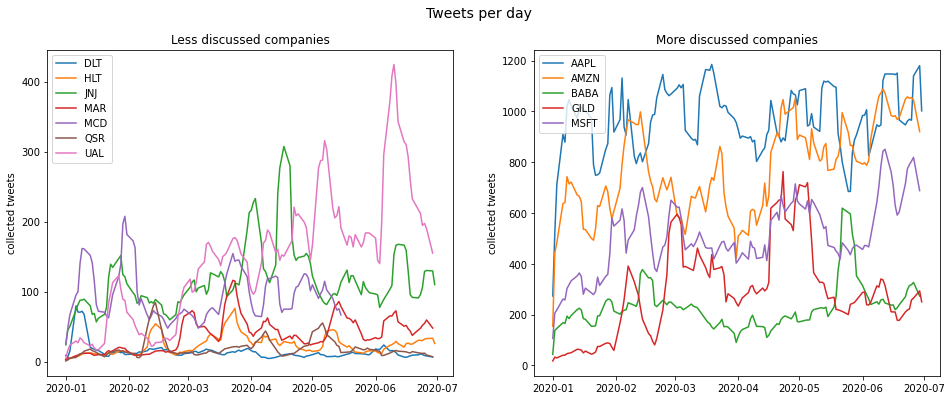

In [57]:
fig_name = 'Tweets per day'
fig, axes = plt.subplots(1,2, figsize=(16,6))

tweet_count = df.groupby(['ticker']).id.count()

high =  tweet_count[tweet_count/tweet_count.max() > 0.20].index
low = tweet_count[tweet_count/tweet_count.max() <= 0.20].index

for ticker in low:
    data = df[df.ticker==ticker].groupby('sentiment_collection_date').id.count().rolling('7D').mean() 
    axes[0].plot(data.index, data.values, label=ticker)
    axes[0].set_ylabel('collected tweets')
    axes[0].set_title('Less discussed companies')
    axes[0].legend()

for ticker in high:
    data = df[df.ticker==ticker].groupby('sentiment_collection_date').id.count().rolling('7D').mean() 
    axes[1].plot(data.index, data.values, label=ticker)
    axes[1].set_ylabel('collected tweets')
    axes[1].set_title('More discussed companies')
    axes[1].legend()
    

fig.suptitle(fig_name, fontsize=14)
plt.savefig(r'c:\Users\jaromir\OneDrive\UoM\100_Disertation\05_Dissertation\01_Figures\\'+fig_name+'.png')
plt.show()

In [47]:
df = df.drop(['weekday','hour','minute','date_short','army_time','sentiment_collection_period'], axis=1)

In [48]:
df.head(3)

,username,to,text,retweets,favorites,replies,id,author_id,date,hashtags,mentions,urls,ticker,sentiment_collection_date
0,DoejiStar,NaN,2019 Jan 2nd (22:30gmt) $JPY flash crash backdrop: - risk aversion sentiment on political risks ...,0,2,0,1212522035525476352,507108497,2020-01-01 23:52:35+00:00,#Caixin,NaN,NaN,AAPL,2020-01-02
1,PigOfFed,MarcoMNYC,"Should've been $spx 4,000 i mean the fed balance sheet is never going down again, $aapl at 400 &...",0,1,0,1212521491398565894,1182741182310486016,2020-01-01 23:50:25+00:00,NaN,NaN,NaN,AAPL,2020-01-02
2,mikeharrisNY,NaN,Market driver 2019. $AAPL had highest approx. turnover (price x volume) in $DJIA,1,12,0,1212520476129583104,179571631,2020-01-01 23:46:23+00:00,NaN,NaN,NaN,AAPL,2020-01-02


In [50]:
# save file
current_time = str(datetime.now().strftime("%Y%m%d_%H%M%S"))

In [51]:
df.to_pickle(r"c:\Users\jaromir\OneDrive\UoM\100_Disertation\02_SrcData\04_CleanData\tweets_"+current_time+".pkl")

In [52]:
# df_for_man_label = df.copy()
# df_for_man_label = df_for_man_label.loc[:,df_for_man_label.columns.isin(['text','id','date','ticker'])]

In [53]:
# df_out = pd.DataFrame(columns = ['text','id','date','ticker'])
# for tick in df_for_man_label.ticker.unique():
#     df_out = df_out.append(df_for_man_label[df_for_man_label.ticker == tick].sample(75, replace = False), ignore_index=True)

In [54]:
# df_out

In [55]:
# df_out.to_csv(r"c:\Users\jaromir\OneDrive\UoM\100_Disertation\02_SrcData\04_CleanData\tweets_"+current_time+".csv")